### To see, or not to see,  
## (code):

In [1]:
# create toggle for hiding or displaying raw code
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [2]:
# hide warning messages
import warnings
warnings.filterwarnings('ignore')

<center>
<h1><span style="font-size:62px;font-family:Times New Roman,Times,serif"><tt>Credit Card Fraud Detection</tt></span></h1>
</center>
<br>


### Author: Jan Erish Baluca
[**LinkedIn**](https://www.linkedin.com/in/jan-erish-baluca-099569103/)  
[**Portfolio on Github**](https://github.com/JanErish/Portfolio_von_Jan)  

**Primary Task:** Build a **Supervised** Machine Learning Model for Detecting Credit Card Fraud  
**Secondary Tasks:**    
* Compare different models to determine which model performs best for the task   
* Use **resampling, hyperparameter tuning, and extreme gradient boosting** methods to improve model performance  
- Use **cross-validation** to measure model performance   
- Demonstrate skill in building custom complex custom functions


**Tools**: Machine Learning: _Supervised Learning_ using **Python**'s **scikit-learn** and **xgboost** packages.    

**_Always a work in progress! Will be continuously adding new models and improving implemented ones._**

**Data**:  
* Credit card transactions in September 2013 by european card holders that occured in two days.  
* All the features are numeric as a result of PCA (Principal Component Analysis) transformations (except 'Time' and 'Amount').  
- _Due to confidentiality issues, the original features and background information are not available._  
- **'Class'** is the target variable. The value **1** is for cases of fraud and **0** for otherwise.  

[_Dataset Source: Kaggle_](https://www.kaggle.com/mlg-ulb/creditcardfraud/data)

![Imgur](https://i.imgur.com/gWdvLWB.png)

# Table of Contents
## Part 1: Supervised Learning Basic Steps   
1. [Exploratory Data Analysis](#eda)  
2. [Feature Importance](#feat)  
    2.1 [Principal Component Analysis](#pca)
3. [Distribution](#dist)  
4. [Logistic Regression](#logreg)  
5. [Evaluating Model Performance](#perf)  
    5.1. [Base Rate Model](#base)  
6. [Other Models](#other)  
    6.1 [k-Nearest Neighbors](#knn)  
    6.2 [Random Forest / Decision Trees](#forest)  
    6.3 [Naïve Bayes Classifier](#nbae)  
    6.4 [Kernel Support Machine Vector](#svm)    
7. [Receiver Operating Characteristic Curve](#roc)  
8. [Probability: Logistic Regression Coefficients](#coeff)  

## Part 2: XGBoost Model Training Pipeline (COMING SOON)
1. [Description](#desc)

In [3]:
%matplotlib inline

In [4]:
# Importing the data and basic packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('creditcard.csv')
df = df.drop('Time', axis=1)
df.reset_index(inplace=True)

<a id="eda"></a>  
# Exploratory Data Analysis

It is important to always conduct exploratory data analysis before attempting to create a predictive model.

A **correlation matrix** is always a good way to start.
We can visualize it using seaborn's Heat Map.

But first, let us check for missing values.

In [5]:
# Numerical EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
index     284807 non-null int64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26    

It seems like there are no missing values. We can now proceed with the correlation matrix.

In [6]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

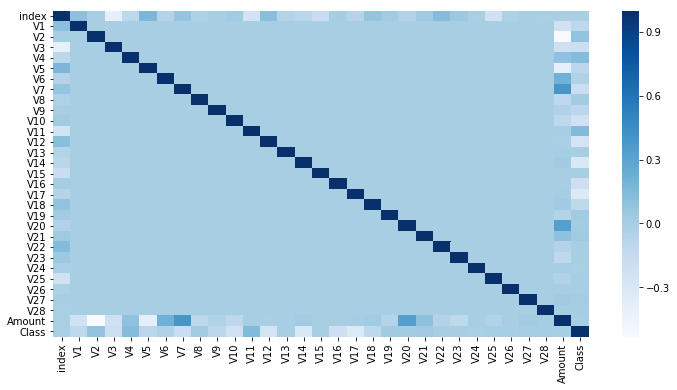

In [7]:
# Correlation Matrix
corr = df.corr()
plt.figure(figsize=(12,6))
hm = sns.heatmap(corr, yticklabels=corr.columns.values, xticklabels=corr.columns.values, cmap="Blues")
plt.show()

target_corr = pd.DataFrame(corr.iloc[-1,:-1]).reset_index()

The heatmap reveals the intensity of correlations between all the features in our dataset.

What's important, however, is the relationship of the features with our target, which is the Class.

It is more helpful to isolate Class's relationship with the rest of the features.

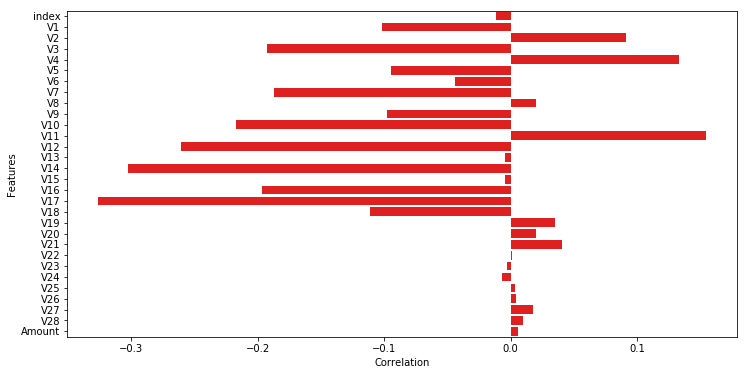

In [8]:
plt.figure(figsize=(12,6))
fig = sns.barplot(x='Class', y='index', data=target_corr, color='r')
fig.set(ylabel='Features',xlabel='Correlation')
plt.show()

We see that quite a number of the features have a notable negative correlations with our target. Only about three have considerable positive correlations.

Let us examine V17 and V14, our top two contenders for our team of strong predictors.

A scatter plot is an intuitive way to check if there are clusters of legitimate and fraudulent transactions based on these two features.

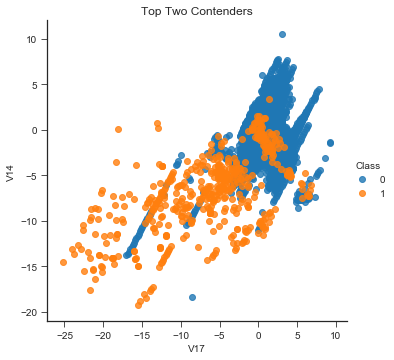

In [9]:
# Scatter Plot: V17 vs. V14
plt.figure(figsize=(12,6))
sns.set_style('ticks')
lmplot = sns.lmplot('V17','V14', data=df,hue='Class', fit_reg=False)
plt.title('Top Two Contenders')
plt.xlabel('V17')
plt.ylabel('V14')
plt.show()

It seems that these two features really do make our two clusters, fraudulent and legitimate transactions, very visible. There are, however, very serious overlaps between the two clusters.

I wonder what adding a third feature into the mix would do...

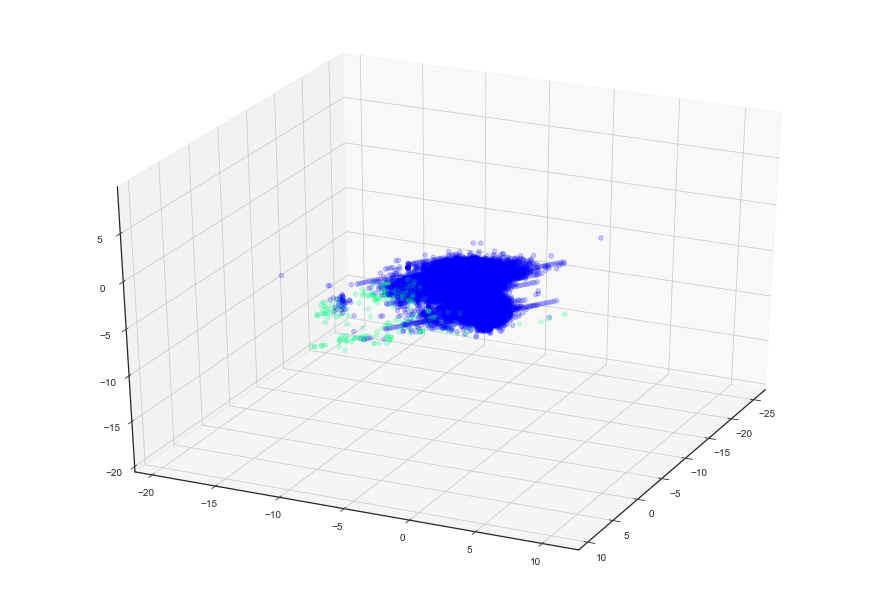

In [10]:
# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.figure(figsize=(12,8))
ax = Axes3D(plt.gcf())
ax.scatter(xs=df['V17'],ys=df['V14'], zs=df['V12'], c=df['Class'], s=20, cmap=pylab.cm.winter, alpha=0.2)
ax.view_init(azim=25)

Looks like our third dimension further reflects our clustering.

<a id="feat"></a>  
# Feature Importance

Our plots show that some features have very strong relationships with the target, while some have very weak correlation.

It is very important to get rid of features that will not help in classifying transactions. 

A **decision tree classifier** can be used to rank features used for prediction.  

The [intuition](#forest) behind the classification tree is explained further below.  

In [11]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)

# Split into train and test sets
target_name = 'Class'
X = df.drop(target_name, axis =1)
sc_X = StandardScaler()
X = pd.DataFrame(sc_X.fit_transform(X))
y = df[target_name]


# Is it recommended to stratify in order to keep the same proportion of 1s and 0s
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dtree = tree.DecisionTreeClassifier()
    #class_weight='balanced')
                                    #min_weight_fraction_leaf=0.01)
dtree = dtree.fit(X_train,y_train)

# Plot!

importances = dtree.feature_importances_
feat_names = df.drop(['Class'], axis=1).columns

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Which features should we keep?")
plt.bar(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical', fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

NameError: name 'plt' is not defined

Let's hire our top 4 contenders as our Strong Predictor Team!

In [21]:
# Drop unwanted features
team = feat_names[np.argsort(importances)[-4:]]
X = df[team]
print(X.info())

# Split into train and test sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 4 columns):
V10    284807 non-null float64
V12    284807 non-null float64
V14    284807 non-null float64
V17    284807 non-null float64
dtypes: float64(4)
memory usage: 8.7 MB
None


<a id="pca"></a>
# Why the features have no names: Principal Component Analysis (PCA)

As mentioned in the introduction, the features or variables in the dataset have no names because they are products of Principal Component Analysis (PCA).

<p><div style="text-align: justify">
<b>Principal Component Analysis (PCA)</b> is a dimension reduction technique. It decorrelates data by aligning the data with the axes, shifting data samples so that have a mean of 0. It does not discard data. Instead, the data is condensed into a smaller set of new dimensions, with a minimum loss function.  
</div></p>

**Its goals are:  **
1. To look for properties that show as much variation across instances as possible
2. To look for properties that allow to predict or "reconstruct" the original characteristics  

In doing this, it effectively **_reduces statistical noise_**, or unexplained variations in the sample. 

<a id="dist"></a> 
# Distribution

Before we proceed with testing models for our binary classification task, it is of utmost importance to check out the distribution of classes. 

In [23]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

Fraud Transactions: 492
Total Transactions: 284807
Fraud Ratio: 0.17%


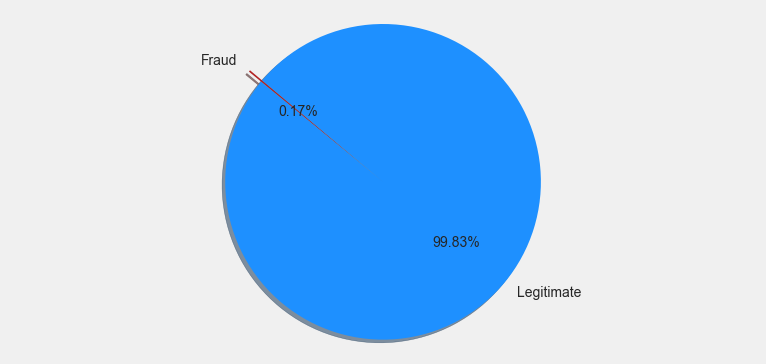

In [24]:
fraud_count = df['Class'].sum()
transactions_count = df['Class'].count()
legitimate_count = transactions_count - fraud_count
fraud_ratio = fraud_count/transactions_count
print("Fraud Transactions: {}".format(fraud_count))
print("Total Transactions: {}".format(transactions_count))
print("Fraud Ratio: {:0.2f}%".format(fraud_ratio*100))

# Data to plot
labels = ['Fraud', 'Legitimate']
sizes = [fraud_count, legitimate_count]
colors = ['firebrick', 'dodgerblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        shadow=True, startangle=140, autopct='%1.2f%%')
#plt.title("Percentage of Transactions that are Fraudulent") 
plt.axis('equal')
plt.show()

## It's Skewed! How do we deal with it?
Looks like we have a case of severe **class imbalance**!   
With such a skewed distribution of class, we cannot simply rely on model precision in evaluating performance.

_There are two errors that we want to minimize in our predictions:_

>**_False Positives (Type I Error)_**  
>>    = label as Fraud (1), but transaction is actually legitimate

>**_False Negatives (Type II Error)_**  
>>    = label as Legit (0), but transaction is actually fraudulent
    
Given our task at hand, **_what we really want to minimize are the false negatives_**.  
How do we measure performance based on these, then? Let's get back to that later.

For now, let us proceed with building our first predictive model: Logistic Regression.

<a id="logreg"></a> 
<span style="font-size:25px;font-weight:bold;color:#b22222"> Logistic Regression  </span>

Unlike Linear Regression, Logistic Regression is used for classification problem.
It produces probabilities for each case. By default, the threshold is 0.5.
If the probability is greater than 0.5, the data is labelled as 1.
If the probability is less than 0.5, the data is labelled as 0.
It creates a linear decision boundary.

Additionally, in order to find the best parameters for our Logistic Regression model, we will use **Hyperparameter Tuning**.
GridSearchCV tries out all values from a given range as our hyperparameter and returns the value that gives the best performance score.

In [25]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

# Hyperparameter Tuning
logreg = LogisticRegression()
c_space = np.logspace(-5, 8, 15)
param_grid = {'C' : c_space}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression: Best Score: {}".format(logreg_cv.best_score_))

# Using our best paramters
logreg = LogisticRegression(**logreg_cv.best_params_)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Evaluating the Model
logreg_roc_auc = roc_auc_score(y_test, y_pred_prob)
print("Logistic Regression AUC Score: {}".format(logreg_roc_auc))

# Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

# Compute cross-validated AUC scores
cv_auc_logreg = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print("Logistic Regression Cross-validated AUC scores: {}".format(cv_auc_logreg))


Tuned Logistic Regression Parameters: {'C': 3.7275937203149381}
Tuned Logistic Regression: Best Score: 0.999161710812175
Logistic Regression AUC Score: 0.9562708876459982
Logistic Regression Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.81      0.57      0.67        98

avg / total       1.00      1.00      1.00     56962

Logistic Regression Cross-validated AUC scores: [ 0.97725598  0.9792489   0.95118037  0.93253369  0.9280713 ]


<span style="font-size:20px;font-weight:bold;color:#2E86C1"> Logistic Regression: 2D Decision Boundary  </span>
<br>
While we cannot intuitively visualize a 4-dimensional model, we can isolate only the top 2 features to be be able to see the decision boundary that a Logistic Regression model creates for classification.  

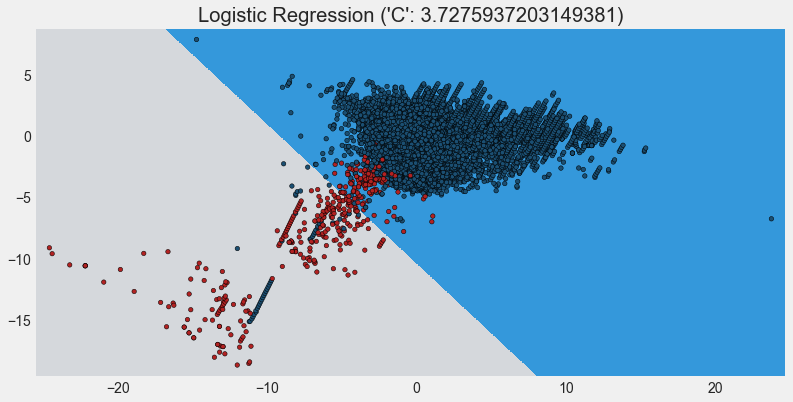

In [29]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#3498DB', '#D5D8DC'])
cmap_bold = ListedColormap(['#1B4F72', '#b22222'])

# Using our best paramters
logreg_2d = LogisticRegression(**logreg_cv.best_params_)
logreg_2d.fit(X_train.iloc[:,:2], y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = logreg_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Logistic Regression ('C': 3.7275937203149381)")

plt.show()

<a id="perf"></a> 
# Evaluating Model Performance

*So what do the scores above even mean?*

**Precision:** the ratio of correctly labelled fraudulent transactions to the total transactions classified as fraudulent. 

  (True Positives / (True Positives + False Positives))  
>  **_High Precision_**  
> >= low false positive rate  
= not many legit transactions classified as fraud

**Recall:** ratio of correctly labelled fraudulent transactions to the total number of correctly labelled fraud AND undetected fraud.

  (True Positives / (True Positives + False Negatives))  
>  **_High Recall_**  
> >= low false negative rate  
= predicted most fraud transactions correctly
        
**F1 Score:** harmonic mean of precision and recall

Since we have a skewed data (very low proportion of fraudulent transactions), we should aim to maximise our Recall. 

The **ROC Curve** (Receiver Operating Characteristic Curve) plots and illustrates the true positive rates (TPRs) and the false positive rates (FPRs) over a range of threshold settings. In logistic regression (the default is 0.5 probability), this is from 0.0 to 1.0. 

_However, since we are looking at a dataset with very high class imbalance, it is better to look at the **Area Under the ROC Curve (AUC)**. The larger the area under the ROC curve, the better the model._

**Cross-validation** is simply for ensuring that the score is not being strongly affected by the way the original dataset has been split.

Before plotting our AUCs, let us use other Supervised Learning models first.

<a id="base"></a> 
# Base Rate for Accuracy

To provide a reference point for our scores, we need a base rate.  
It tells us how much of the data is labelled 0. The scores of our models must be above the base model scores.

In [31]:
# Base Rate Model?!?!
from sklearn.metrics import accuracy_score
def bsr(X):
    y=np.zeros(X.shape[0])
    return y
y_bsr = bsr(X_test)
print("Base Rate accuracy: %2.2f" % accuracy_score(y_test, y_bsr))
base_roc_auc = roc_auc_score(y_test, y_bsr)
print("Base Rate AUC = %2.2f" % base_roc_auc)
print("Base Rate Classification Report:\n{}".format(classification_report(y_test, y_bsr)))

Base Rate accuracy: 1.00
Base Rate AUC = 0.50
Base Rate Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.00      0.00      0.00        98

avg / total       1.00      1.00      1.00     56962



<a id="other"></a> 
# Other Supervised Learning Models
<a id="knn"></a> 
<span style="font-size:25px;font-weight:bold;color:#b22222"> k-Nearest Neighbors  </span> 

This model predicts the label of a data point by looking at the 'k' number of closest labelled data points and taking a majority vote.

Since we are not sure which number of data points to consider would give the best results, we will also use **Hyperparameter Tuning** on our model.

### k-NN performance:

In [33]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid={'n_neighbors': np.arange(1,10)}
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print("Hyperparameter Tuning: Best Parameter: {}".format(knn_cv.best_params_))
print("Hyperparameter Tuning: Best Score: {}".format(knn_cv.best_score_))

knn = KNeighborsClassifier(**knn_cv.best_params_)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
print("kNN score: {}".format(knn_score))
print("kNN AUC Score: {}".format(knn_roc_auc))
print("kNN Classification Report:\n{}".format(classification_report(y_test, knn.predict(X_test))))
# Compute cross-validated AUC scores
cv_auc_knn = cross_val_score(knn, X, y, cv=5, scoring='roc_auc')
print("k-NN Cross-validated AUC scores: {}".format(cv_auc_knn))

Hyperparameter Tuning: Best Parameter: {'n_neighbors': 5}
Hyperparameter Tuning: Best Score: 0.9994996598564814
kNN score: 0.9995611109160493
kNN AUC Score: 0.8979152191264801
kNN Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.94      0.80      0.86        98

avg / total       1.00      1.00      1.00     56962

k-NN Cross-validated AUC scores: [ 0.94904295  0.92412643  0.86151794  0.93336589  0.87224638]


<span style="font-size:20px;font-weight:bold;color:#2E86C1"> k-NN: 2D Decision Boundary  </span>
<br>  
While we cannot intuitively visualize a 4-dimensional model, we can isolate only the top 2 features to be be able to see the decision boundaries that a k-Nearest Neighbor model creates for classification.  

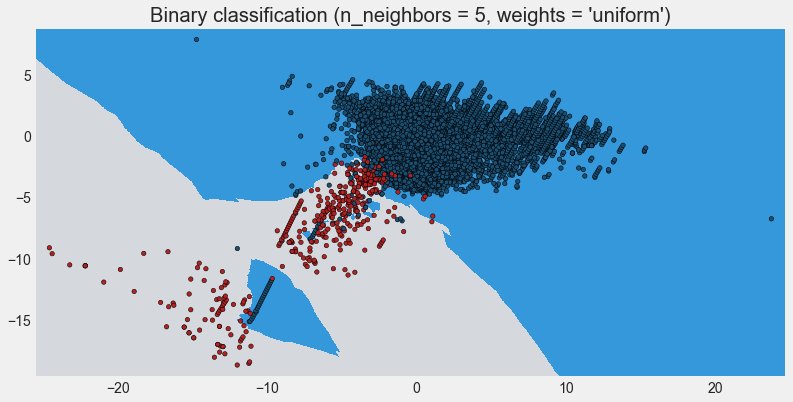

In [36]:
# create a 2D knn model
knn_2d = KNeighborsClassifier(n_neighbors=5)
knn_2d.fit(X_train.iloc[:,:2], y_train)


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Binary classification (n_neighbors = 5, weights = 'uniform')")

plt.show()

<a id="forest"></a> 
<span style="font-size:25px;font-weight:bold;color:#b22222"> Random Forest  </span>

### Decision Tree and Random Forest Intuition:
Simply put, a **Decision Tree Classifier** creates splits in our data in order to minimize information entropy (the unpredictability).  
* It maximizes the number of "leaves" or data points in each "tree" or split in data.  
* This old technique has been steadily losing popularity until it was recently revived with upgrades through tech innovations.  
* One such upgrade is the _Random Forest Model_.  

The following is a visualization of a Decision Tree fitted to a training set that contains only our top 4 features and the dependent variable:   

In [38]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

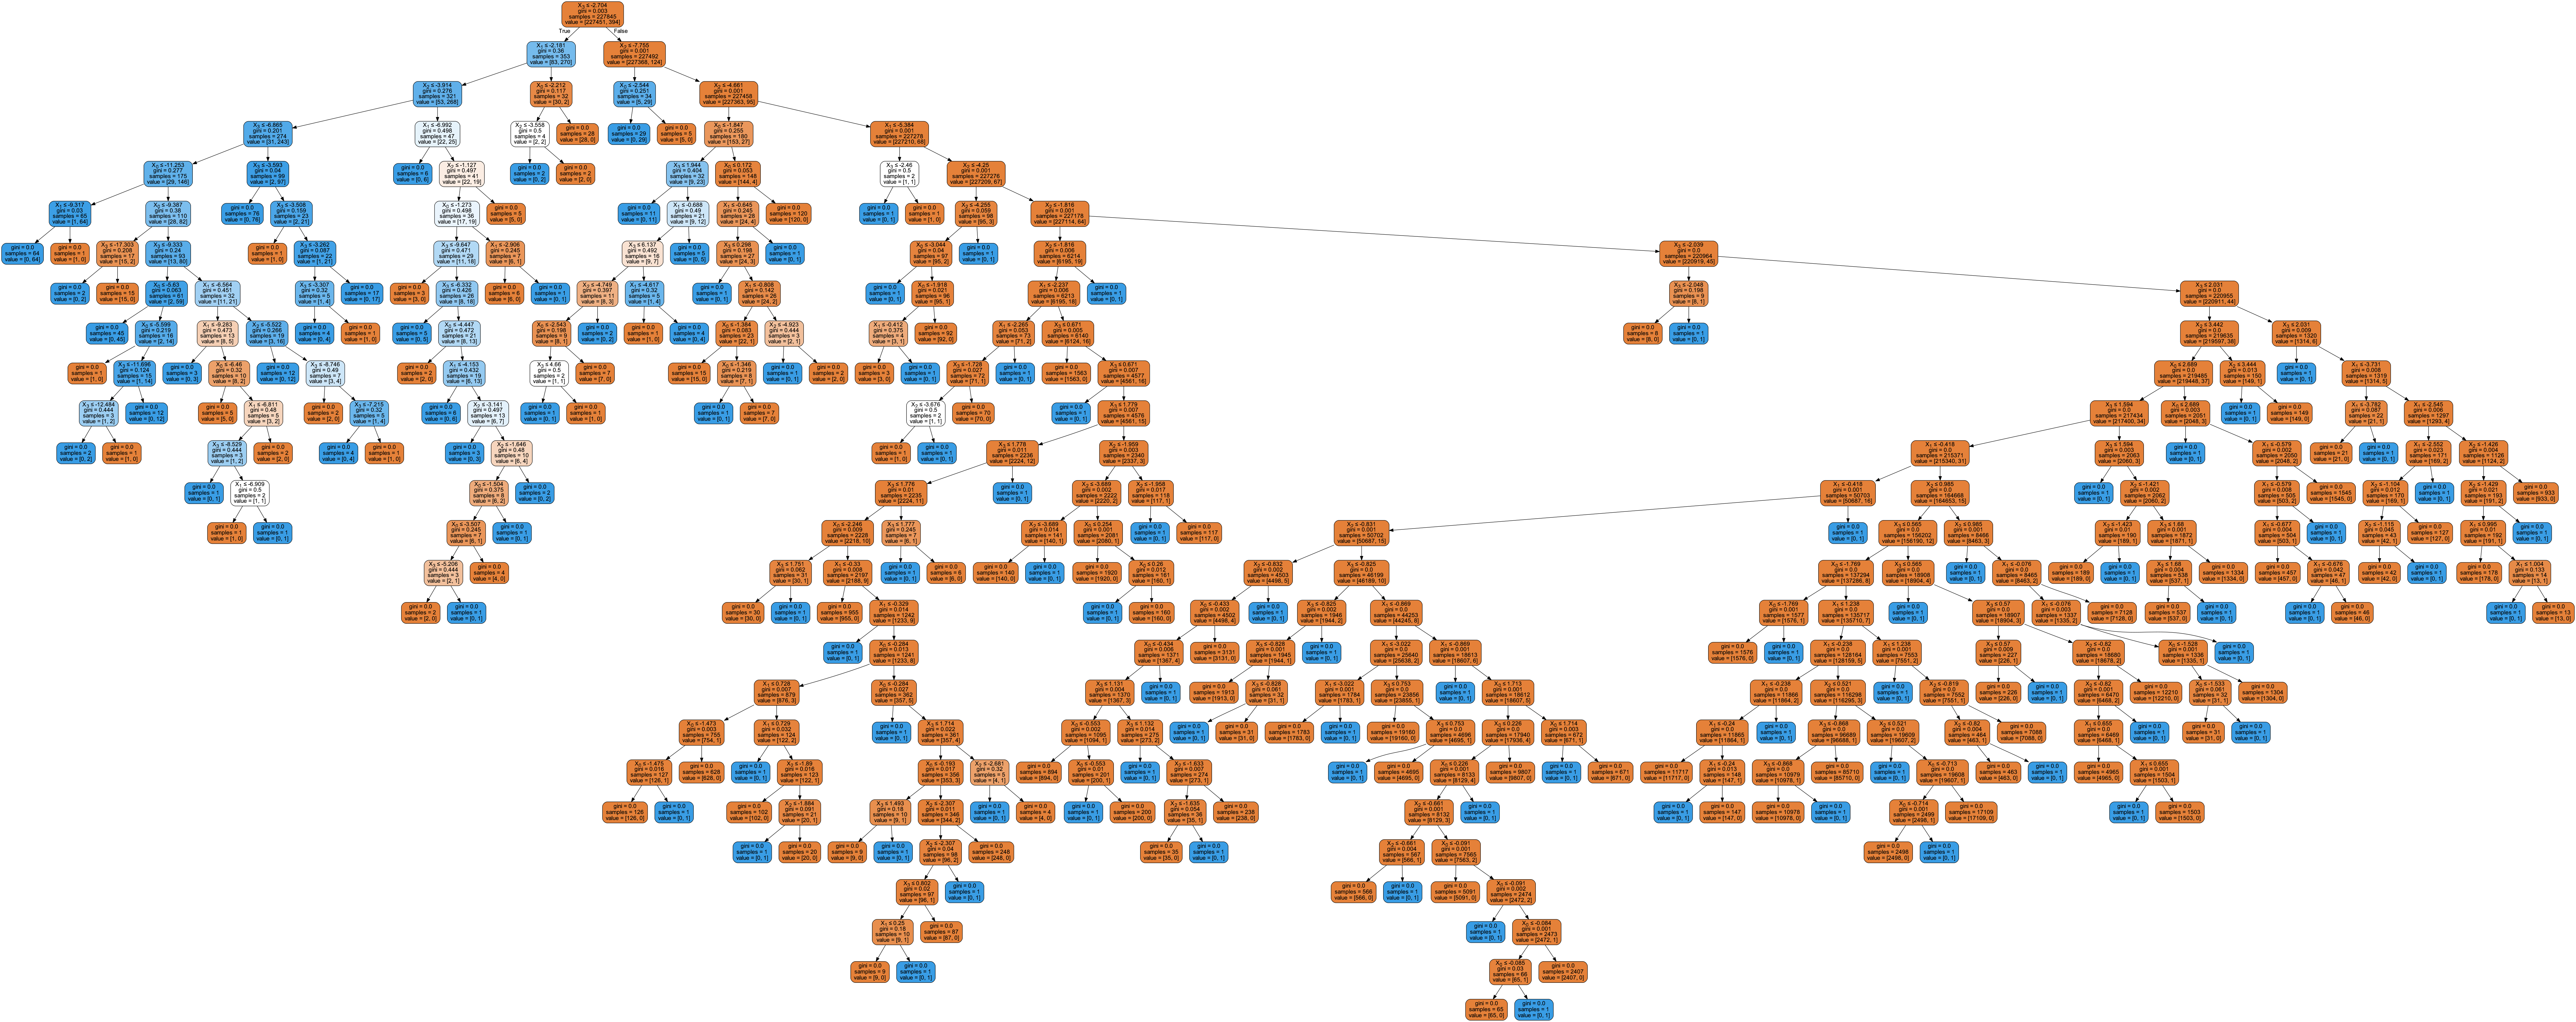

In [39]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dtree = dtree.fit(X_train,y_train)
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

A **Random Forest Model** uses _Ensemble Learning_:  
* It creates a selected number of decisions trees trained by historical data.  
* Each new data point is then passed through this forest of decision trees and is assigned to the category that wins the majority vote (_imagine! trees having the right to vote..._).  

In [41]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [42]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, class_weight="balanced")
rf.fit(X_train, y_train)
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print("Random Forest AUC score: {}".format(rf_roc_auc))
print("Random Forest Classification Report:\n{}".format(classification_report(y_test, rf.predict(X_test))))

Random Forest AUC score: 0.897924012035878
Random Forest Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.95      0.80      0.87        98

avg / total       1.00      1.00      1.00     56962



<a id="nbae"></a>
<span style="font-size:25px;font-weight:bold;color:#b22222"> (Gaussian) Naïve Bayes Classifier   </span>

Another classifier that returns probabilities is the **Naïve Bayes Classifier**, which is based on _Bayesian Theorem_. It describes the probability of an event based on prior knowledge of conditions that might be related to said event.

What makes is "naïve" is its base assumption that the variables we are working with are independent - the assumption of **independence**.  
Often times, the assumption is not correct, but it works anyway.

In [44]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [45]:
# Gaussian Bayesian Model
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)
NB.score(X_test, y_test)
NB_roc_auc = roc_auc_score(y_test, NB.predict(X_test))
print("Naive Bayes AUC score: {}".format(NB_roc_auc))
print("Naive Bayes Classification Report:\n{}".format(classification_report(y_test, NB.predict(X_test))))

Naive Bayes AUC score: 0.933728380209709
Naive Bayes Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56864
          1       0.13      0.88      0.23        98

avg / total       1.00      0.99      0.99     56962



*Our Naive Bayes classifier seems to have horrible precision! However, it does have a pretty good AUC score.*

<span style="font-size:20px;font-weight:bold;color:#2E86C1"> Gaussian Naïve Bayes: 2D Decision Boundary  </span>
<br>
While we cannot intuitively visualize a 4-dimensional model, we can isolate only the top 2 features to be be able to see the decision boundary that a Gaussian Naïve Bayes model creates for classification.  

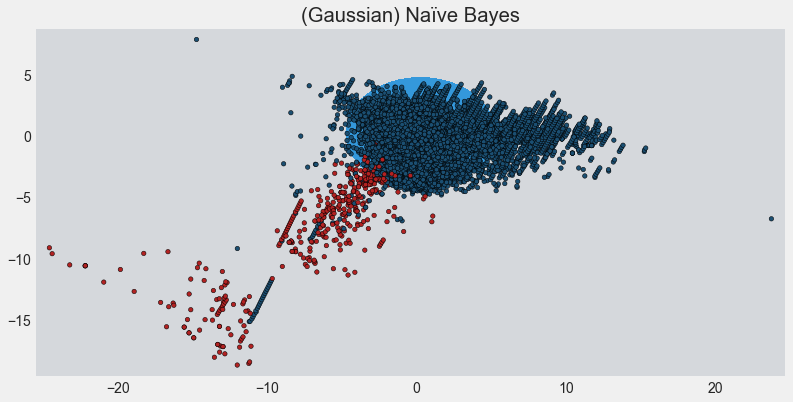

In [47]:
NB_2d = GaussianNB()
NB_2d.fit(X_train.iloc[:,:2], y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = NB_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("(Gaussian) Naïve Bayes")

plt.show()

<a id="svm"></a>
<span style="font-size:25px;font-weight:bold;color:#b22222"> Kernel SVM (Support Vector Machine) Classifier  </span>

### SVM Intuition:

Like in our previous machine learning models, SVM also creates a decision boundary in order to classify data points, or rather, "**vectors**." In a multidimensional space, data entries are referred to as "vectors" since when there is more than two dimensions, they can no longer be a "point." In a multi-dimensional space, our decision boundary is then called a "**Hyperplane**."  

What makes SVM unique is the way it determines the decision boundary.  
Most algorithms would try to learn from the most orange-ish of oranges and the most apple-ish of apples to be able to classify incoming unknown fruits.  
SVM, on the other hand, looks at the most orange-ish apple and the most apple-ish orange in order to decide the decision boundary. These extreme cases are the two **_support vectors_**. The line that separates our classes are based on these two.  

But what happens when a dataset is _non-linearly separable_? For example, a cluster of a class might be completely surrounded by vectors of another class.  
What SVM does is that it uses a mapping function to bring the computation to a _higher dimension_ (a second, third, or more), creates a decision boundary at this level, and then projects it back to the original dimension/s.  
The problem with this, however, is that is computationally demanding. This is why in our case, we will use the **_Kernel_** trick, which is capable of doing the same without requiring computation at a higher dimension.  

**Let's get to it!**

In [49]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [50]:
from sklearn.svm import SVC

# let us use a Gaussian RBF Kernel
kSVM = SVC(kernel='rbf', random_state=42, probability=True)
kSVM.fit(X_train, y_train)
kSVM.score(X_test, y_test)
kSVM_roc_auc = roc_auc_score(y_test, kSVM.predict(X_test))
print("Kernel SVM AUC score: {}".format(kSVM_roc_auc))
print("Kernel SVM Classification Report:\n{}".format(classification_report(y_test, kSVM.predict(X_test))))

Kernel SVM AUC score: 0.8724226008636431
Kernel SVM Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.96      0.74      0.84        98

avg / total       1.00      1.00      1.00     56962



<span style="font-size:20px;font-weight:bold;color:#2E86C1"> Kernel SVM: Decision Boundaries  </span>
<br>
While we cannot intuitively visualize a 4-dimensional model, we can isolate only the top 2 features to be be able to see the decision boundaries that a Kernel SVM model creates for classification.  

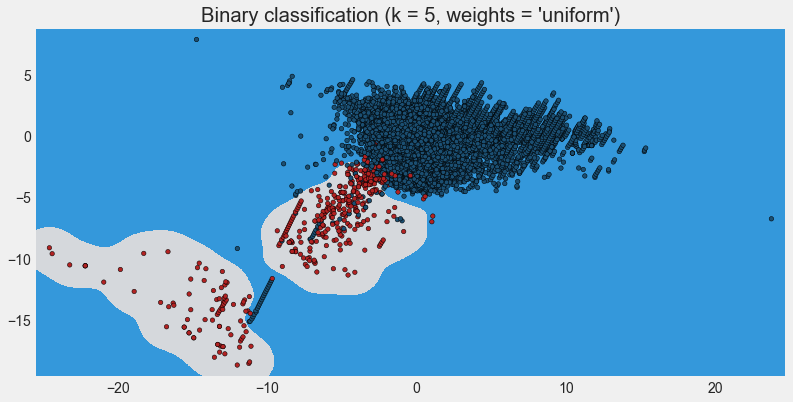

In [52]:
# let us use a Gaussian RBF Kernel
kSVM_2d = SVC(kernel='rbf', random_state=42, probability=True)
kSVM_2d.fit(X_train.iloc[:,:2], y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = kSVM_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Binary classification (k = 5, weights = 'uniform')")

plt.show()

<a id="roc"></a>
# Plotting our ROC curves to check the AUCs

As mentioned earlier, another important method of evaluating model performance in lew of class imbalance is looking at the area under the ROC (Receiver Operating Characteristic) curve.

The larger the area, the better the model!

In [54]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

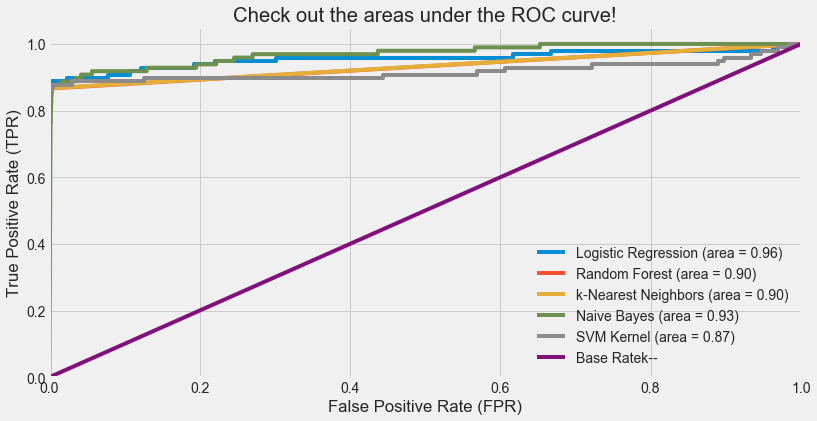

In [56]:
# Plot AUC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
NB_fpr, NB_tpr, NB_thresholds = roc_curve(y_test, NB.predict_proba(X_test)[:, 1])
kSVM_fpr, kSVM_tpr, kSVM_thresholds = roc_curve(y_test, kSVM.predict_proba(X_test)[:,1])

# Plotting Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logreg_roc_auc)

# Plotting Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plotting k-Nearest Neighbors ROC
plt.plot(knn_fpr, knn_tpr, label='k-Nearest Neighbors (area = %0.2f)' % knn_roc_auc)

# Plotting Naïve Bayes ROC
plt.plot(NB_fpr, NB_tpr, label='Naive Bayes (area = %0.2f)' % NB_roc_auc)

# Plotting SVM Kernel ROC
plt.plot(kSVM_fpr, kSVM_tpr, label='SVM Kernel (area = %0.2f)' % kSVM_roc_auc)

# Plotting the Base Rate ROC
plt.plot([0,1], [0,1], label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Check out the areas under the ROC curve!')
plt.legend(loc='lower right')
plt.show()

<span style="font-size:25px;font-weight:bold;color:#b22222"> Conclusion:  </span>  
<br>
<span style="font-size:25px;font-weight:bold;color:#2E86C1"> Looks like Logistic Regression wins this one! :D  </span>

<a id="coeff"></a>
# Probability: Using Logistic Regression Coefficients
_cr. Randy Lao for the idea_  

We can still use our logistic regression results in order to extract the probabilities of fraud for each transaction.  
Let us use the features that made the cut: V10, V12, V14, and V17

In [57]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to view/hide the raw code."></form>''')

In [58]:
# Creating an intercept term for the logistic regression equation
df['int'] = 1
new_df = ['Class','V10', 'V12', 'V14', 'V17', 'int']
df = df[new_df]
X = df.drop(target_name, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
print(df.iloc[153835,:])

# Extracting Feature Coefficients
import statsmodels.api as sm
logit = sm.Logit(y_train, X_train)
logit = logit.fit()
#print(logit.summary())
coefs = logit.params
print("Coefficients:\n{}".format(coefs))
def co (coefs, V10, V12, V14, V17):
    return coefs[4] + coefs[0]*V10 + coefs[1]*V12 + coefs[2]*V14 + coefs[3]*V17 

# Using an actual fraud case from our test set
co1 = co(coefs, df.iloc[153835, 1], df.iloc[153835, 2], df.iloc[153835, 3], df.iloc[153835, 4])
p = np.exp(co1) / (1+np.exp(co1))
print("Probability that our transaction is fraudulent: {:0.2f}%".format(p*100))

Class     1.000000
V10     -20.949192
V12     -11.924955
V14      -3.836781
V17     -15.825136
int       1.000000
Name: 153835, dtype: float64
Optimization terminated successfully.
         Current function value: 0.004394
         Iterations 12
Coefficients:
V10   -0.388449
V12   -0.214273
V14   -0.918022
V17   -0.073760
int   -8.046287
dtype: float64
Probability that our transaction is fraudulent: 99.93%


## Wait, what?

As you can see, logistic regression actually assigns coefficients to each feature.  
These coefficients represent the effect of each feature while also considering each feature's scaling.

Given the values our logistic regression have returned, we have this formula:  

**Fraud Score** = V10(**-0.388449**) + V12(**-0.214273**) + V14(**-0.918022**) + V17(**-0.073760**) + **-8.046287**  
The value -8.046287 is our **constant** that represents the effect of all uncontrolled variables.  
Transaction index **_153835_** is a _fraudulent_ transaction. Its features have the following values:  
**V10** =     -20.949192  
**V12** =     -11.924955  
**V14** =      -3.836781  
**V17** =     -15.825136  
We then apply these values to our formula.
_The result is the probability that our transaction is fraudulent_, which **is 99.93%**

<a id="desc"></a>

<center>
<h1><span style="font-size:48px;font-family:Times New Roman,Times,serif"><tt>Part II</tt></span></h1>
</center>

![Imgur](https://i.imgur.com/WADp795.png)
<center>
<h1><span style="font-size:48px;font-family:Times New Roman,Times,serif"><tt>EXTREME GRADIENT BOOSTING PIPELINE</tt></span></h1>
</center>
<br>
![Imgur](https://i.imgur.com/dwEyicL.png)
<center>
<h1><span style="font-size:6px;font-family:Times New Roman,Times,serif"><tt>image: Shutterstock</tt></span></h1>
</center>
<br>


This section will serve to demonstrate the following skills:
1. Object Oriented Programming: Building complex classes and functions
2. Data Preprocessing
3. Data pipeline (scikit-learn) building
4. Model tuning and cross-validation
5. XGBoost model creation

The end product will be a class or module for easily training XGBoost supervised machine learning models that:
* automatically preprocesses data
    * dealing with missing values
    * encoding categorical variables
    * resampling the dataset to deal with class imbalance and skewdness
    * normalizing features
    * reducing dimensionality
    * selecting important features
* automatically finds the best setting for a model to deal with a specific dataset through hyperparameter tuning
* automatically trains the model using the best parameters found
* automatically evaluates model performance through cross-validation

The advantages of using the class are:
* The end user will not have to backtrack through the source code to change very specific settings.
* The end user will not have to copy paste hundreds of lines of code everytime a model has to be trained.
* Preprocessing and training settings are all packed in each instance and are easy to access and modify.
* The end user will be able to calibrate the same specific configurations for all instances of the XGBoost_trainer with possibly one line, eliminating the need to calibate each one by one.
* The trainer is built from the ground up with expert knowledge: best-practices and conventions in the industry.


<center>
<h1><span style="font-size:38px;font-family:Times New Roman,Times,serif"><tt>!!work in progress!!</tt></span></h1>
</center>